# Store items sales prediction
Given 5 years of daily sales data across 10 stores for 50 items, we have been tasked to forecast the next 3 months of sales. We will be exploring the data using Pandas and building models using ARIMA, tensorflow's DNN regressor, and xgboost.

This is my first competition and I'm still learning the models myself. At the end I share what I learned while building this.

# Import Libraries
Below are all the libraries that we'll use (with some extra for notebook aesthetics).

In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb #xgboost model
import tensorflow as tf #DNN estimator model

In [18]:
path = "C:/Users/amols/OneDrive/Documents/ProbStatForDS/ECE225Project/Store-item-sales-prediction-data/"

In [9]:
plt.rcParams["figure.figsize"] = [16,9]

# Metrics and 2 Models
## Error Metric
We'll be using the Symmetric Mean Absolute Percentage Error as our forecasting error metric. Defining a function saves us from writing the code multiple times.

In [11]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

## Stationarity Test (Dickey Fuller)
Time Series data should be stationary before applying an ARIMA model. Stationary means that the mean, standard deviation, and variance don't change over time. The function below tests whether or not a Time Series is stationary.

In [12]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

## ARIMA Model
General ARIMA model that will be used.

In [13]:
"""def ARIMA(TimeSeries, maxP, maxQ, maxD):
    #Returns ARIMA model (not fitted)
    stepwise_model = auto_arima(TimeSeries, start_p=1, start_q=1,
                           max_p=maxP, max_q=maxQ,
                           start_P=0, seasonal=True,
                           d=1, max_d=maxD, D=1, trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           maxiter=500)
    print(stepwise_model.aic())
    return stepwise_model"""

## XGBoost Model
General xgboost model that will be used.

In [14]:
def xboost(x_train, y_train, x_test):
    """Trains xgboost model and returns Series of predictions for x_test"""
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

# Data Exploration
## Retrieve Data
Open the competition training data. We'll be exploring this before splitting for our models.

In [19]:
df = pd.read_csv(path +'train.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


In [67]:
set(df.store)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [68]:
set(df.item)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50}

## Store Trends
Here we're looking to see if there are any seasonality trends in the total store sales. We'll group by week so we can more clearly see trends in the plots.

In [69]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

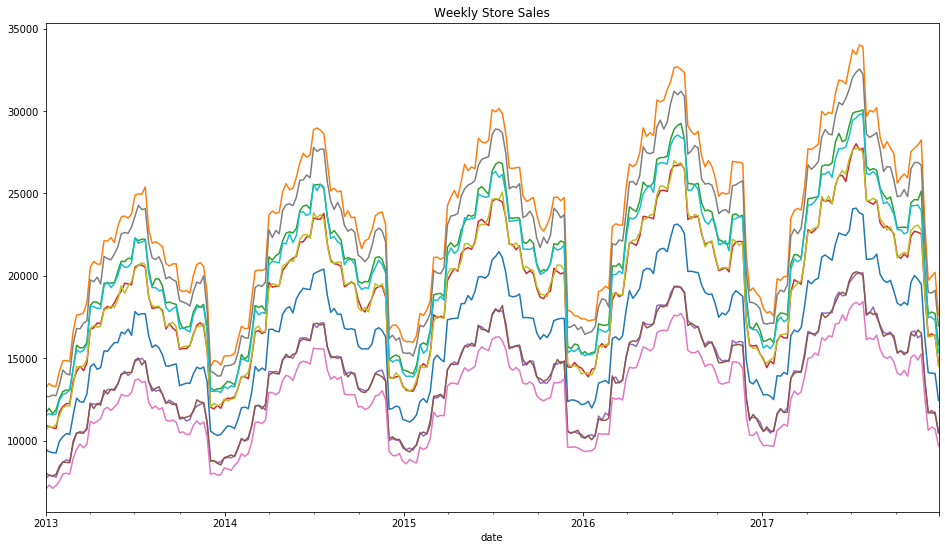

In [70]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

The above plot charts every store's sales by week. But how does the average trend? The 25% quartile?

Let's look:

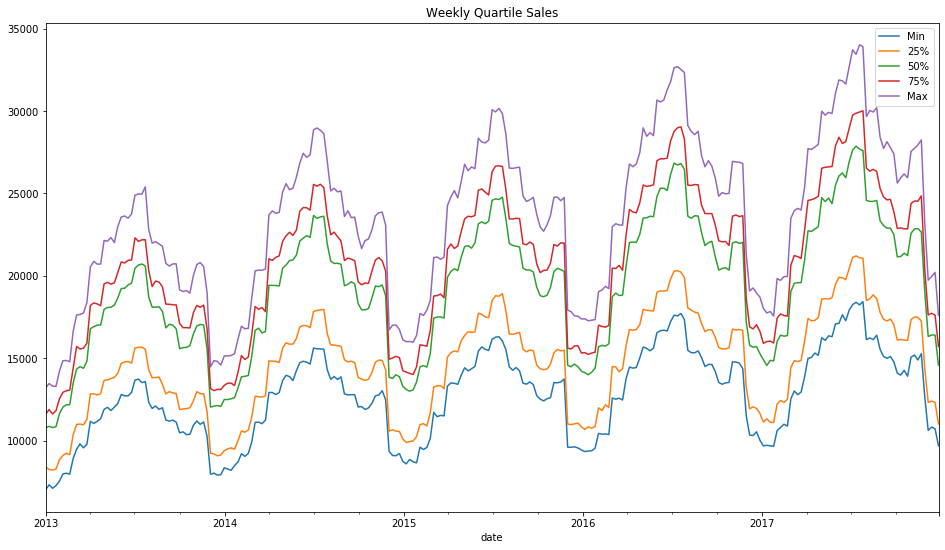

In [23]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

We can see there's quite a gap between the 25% quartile and average. However, as the other chart shows as well, each store shares a general seasonality. They have highs and lows during the same periods of time.

Let's take a look at the seasonality aspect of the average. But before that, we're going to track the week-to-week difference.

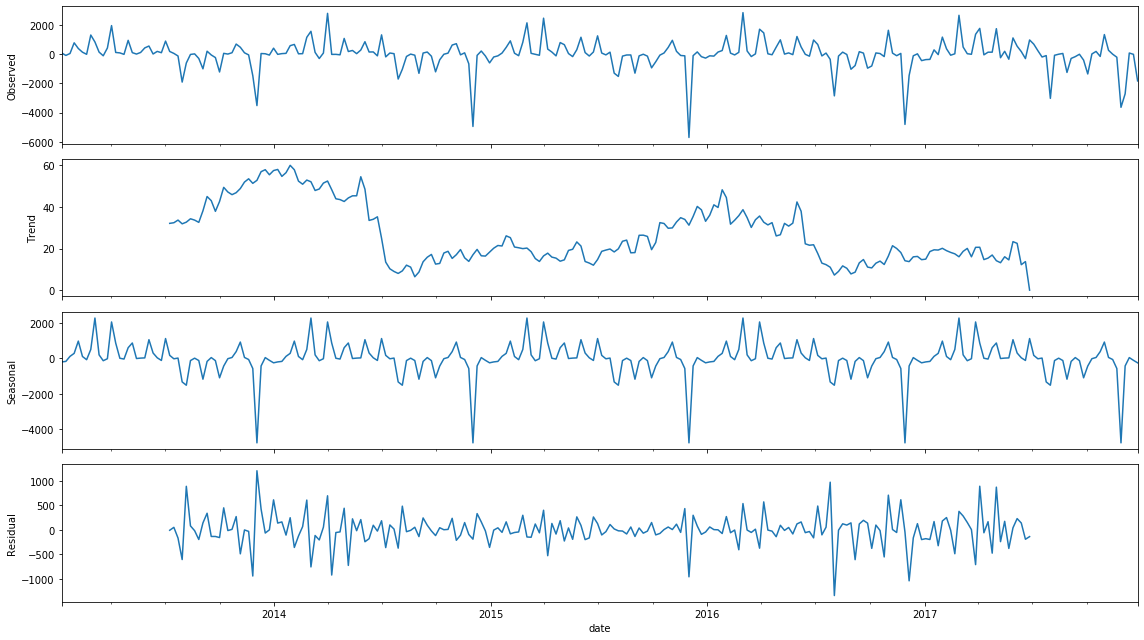

In [24]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [25]:
Fuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -5.965889
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Store Trends Conclusion
There is definitely seasonality in the store sales. Taking the week-to-week difference provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a starting point for our model, we could cluster the stores to the nearest 25% quartile.

## Item Sales Trends
Now we'll do the same analysis for the total item sales. And again, we're looking at weekly sales.

In [26]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail(13)

sales                                                        ...  \
item          1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2017-10-03  1769  4471  2740  1677  1372  4515  4503  5842  3917  5573  ...   
2017-10-10  1758  4454  2858  1757  1392  4483  4510  5932  3861  5771  ...   
2017-10-17  1732  4481  2856  1700  1396  4470  4606  6016  3911  5752  ...   
2017-10-24  1662  4422  2767  1724  1456  4476  4478  6083  3873  5654  ...   
2017-10-31  1774  4798  3087  1680  1476  4766  4837  6415  4276  6088  ...   
2017-11-07  1735  4887  3143  1879  1540  4686  4867  6403  4335  6161  ...   
2017-11-14  1824  4812  3094  1816  1479  4882  4854  6439  4251  5965  ...   
2017-11-21  1818  4840  3076  1876  1576  4835  4936  6427  4181  6053  ...   
2017-11-28  1490  4042  2527  1509  1301  4137  3932  5415  3548  5108  ...   
2017-12-05  1311  3551  2182  1296  1179  3562  3522  4510  3018  4358  ...   
2017-12-12  1308  3498  2251  1277  1125  3541  3381  4699  3014  4372  ...   
2017-12-19  1262  3450  2181  1306  1085  3463  3477  4516  2971  4428  ...   
2017-12-26  1167  3180  1956  1150  1000  2973  3170  4065  2764  3722  ...   

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2017-10-03  1629  2845  3963  2416  6089  4620  1696  3973  2285  5054  
2017-10-10  1741  2815  3892  2338  6213  4529  1644  3949  2208  4967  
2017-10-17  1619  2778  4005  2245  6198  4560  1700  3949  2260  5070  
2017-10-24  1644  2761  3927  2346  6404  4494  1739  4021  2202  5074  
2017-10-31  1817  3038  4318  2386  6623  4889  1798  4257  2468  5323  
2017-11-07  1764  3067  4358  2408  6711  4947  1820  4291  2417  5542  
2017-11-14  1807  3076  4315  2424  6774  4884  1755  4318  2475  5349  
2017-11-21  1872  2987  4273  2392  6530  4915  1860  4329  2364  5517  
2017-11-28  1610  2635  3529  2051  5524  4028  1591  3580  1991  4503  
2017-12-05  1280  2148  2985  1756  4695  3510  1283  3101  1669  3829  
2017-12-12  1349  2213  3100  1785  4721  3483  1279  3051  1701  3856  
2017-12-19  1240  2115  3162  1669  4772  3524  1361  3177  1689  3900  
2017-12-26  1124  1893  2680  1546  4349  3182  1166  2655  1546  3411  

[13 rows x 50 columns]

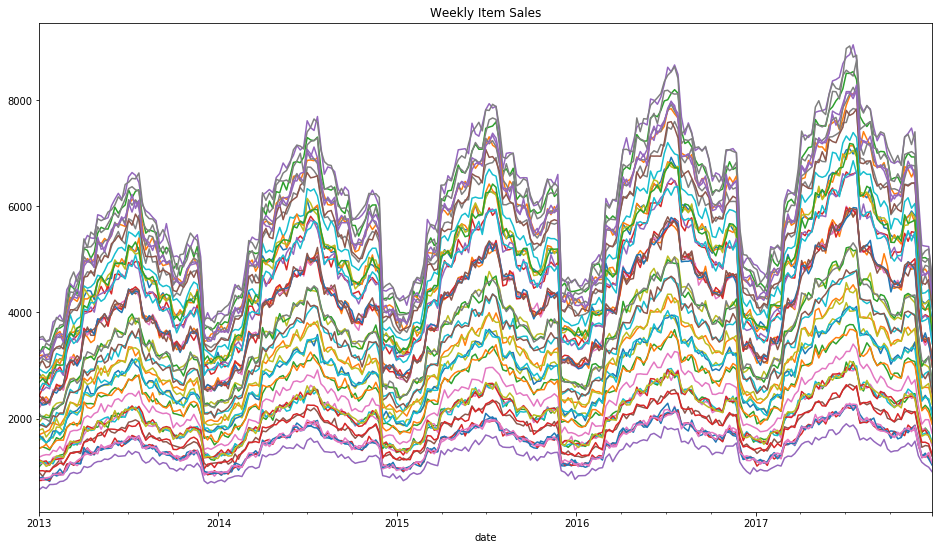

In [27]:
items.plot(figsize=(16,9), title='Weekly Item Sales', legend=None)
plt.show()

Since there are more items than there were stores, we can look at more quartiles. Let's see how every 10% quartile trends.

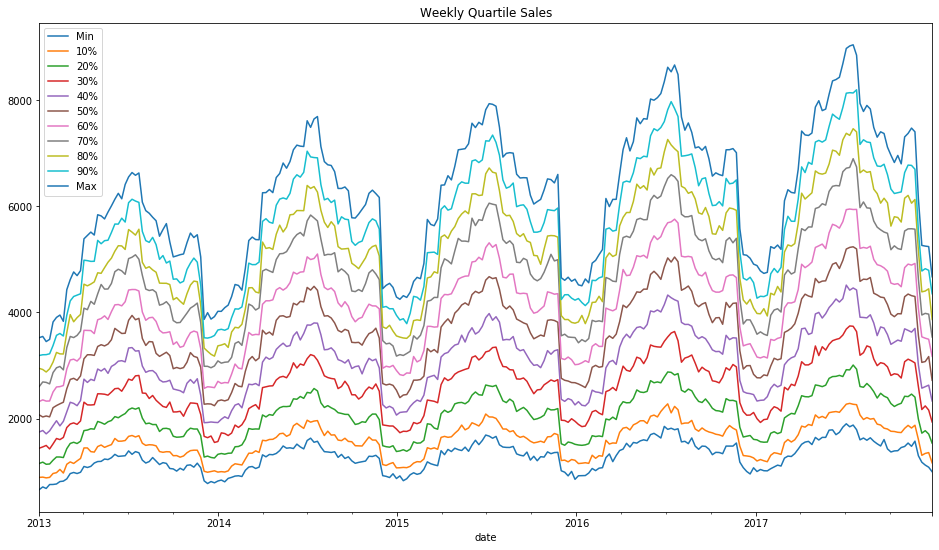

In [28]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

Like we saw in the store sales plots, there is seasonality in item sales. Let's break out the seasonal component for the average like we had before:

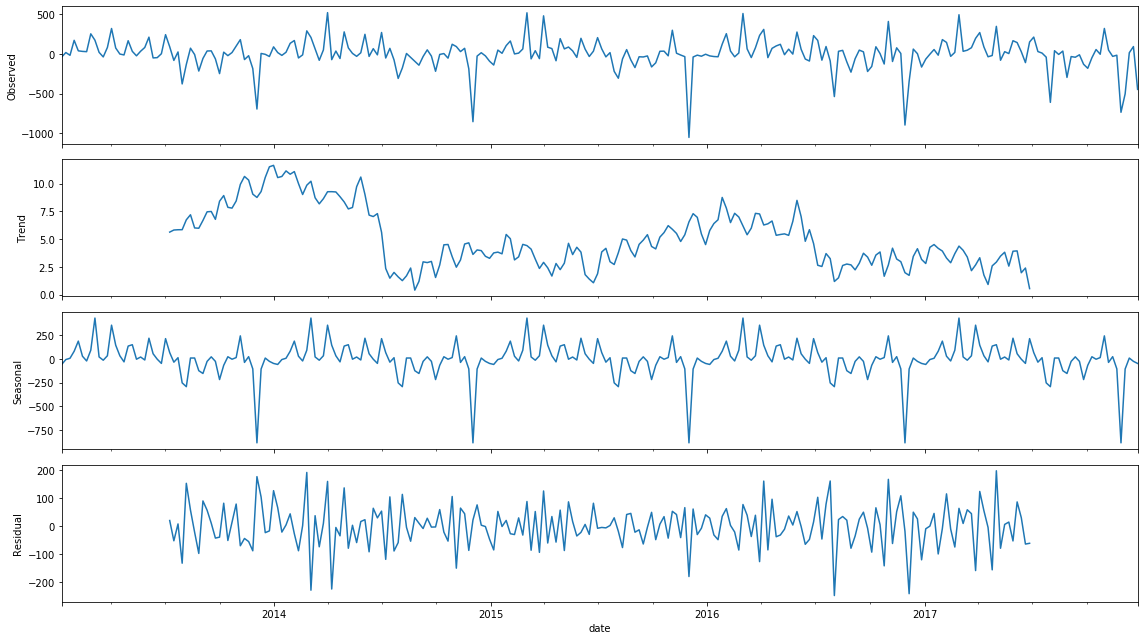

In [29]:
seasonal = seasonal_decompose(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.title = 'Additive Seasonal Decomposition of Average Item Week-to-Week Sales'
plt.show()

In [30]:
Fuller(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -13.061788
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Item Trend Conclusion
Item sales are also seasonal. No surprise there. Week-to-week differencing provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a basis for our model, we could cluster the items to the nearest 10% quartiles.

## Store & Item Variability
We've seen how stores and items trend by themselves, but do some stores sell more of one item? In other words: do the stores have the same sales mix? Are the items sold evenly (percentage-wise) across all stores?

Below is a plot for the % distribution of each item's sales across the stores (each row adds to 100%). As we can see, it's very uniform. The takeaway here is that the items are sold evenly across the stores.

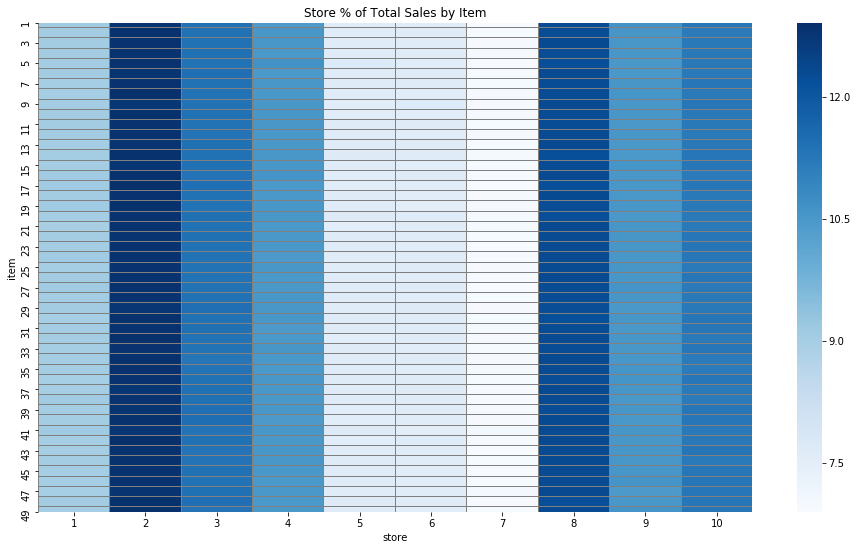

In [31]:
store_item = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()

Now to confirm, let's look at the % distribution of each store's sales across the different items (each row adds to 100%).

We can see that each store overall sold roughly the same percentage of each item.

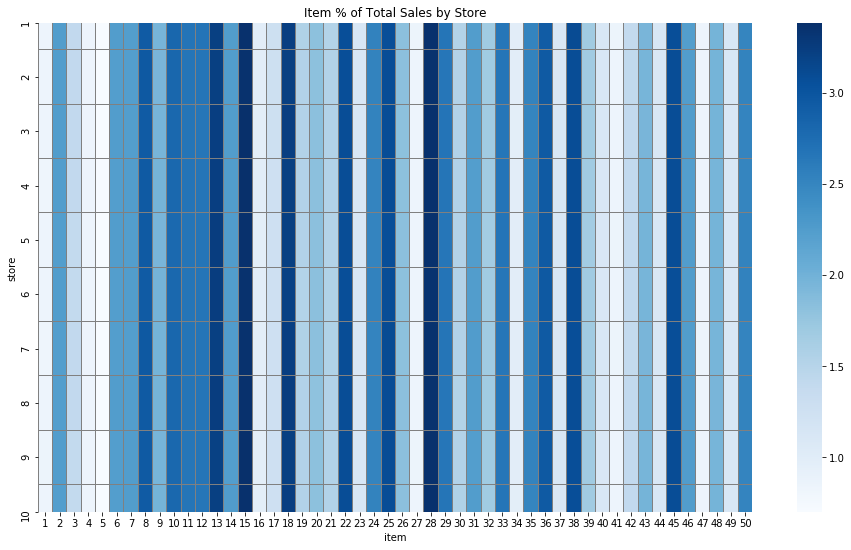

In [32]:
item_store = df.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

### Store vs Item Conclusion
Items have roughly same percentage sales across all stores. We could use this in our model.

## Day of Week Variability
How do sales vary by day of week? Is there seasonality as well? Do stores share same trends? 

In [33]:
df['Day'] = df.index.weekday_name
df.head()

,store,item,sales,Day
date,,,,
2013-01-01,1,1,13,Tuesday
2013-01-02,1,1,11,Wednesday
2013-01-03,1,1,14,Thursday
2013-01-04,1,1,13,Friday
2013-01-05,1,1,10,Saturday


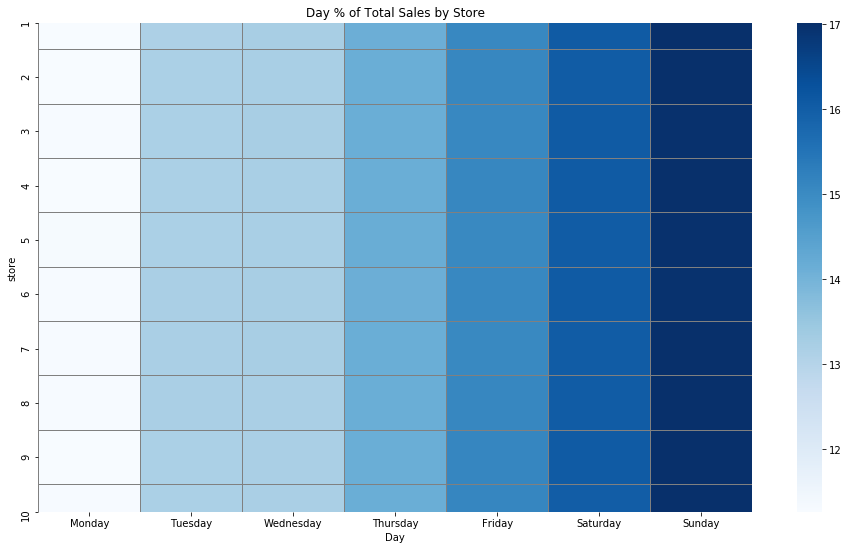

In [34]:
dow_store = df.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_store, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

The plot above shows the % mix of store sales by day. We can see that the stores are very similar in what days are popular.

Let's do the same for the items.

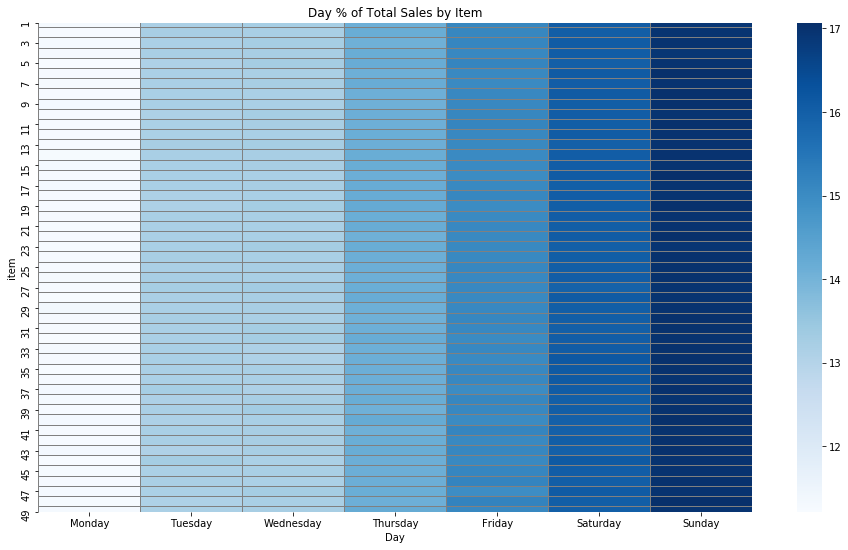

In [35]:
dow_item = df.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Item')
plt.show()

This plot tells us that each item's sales are nearly identical in terms of which days are more popular.

Now let's see if each day generally trends the same as the total week.

In [36]:
dow = pd.DataFrame(df.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

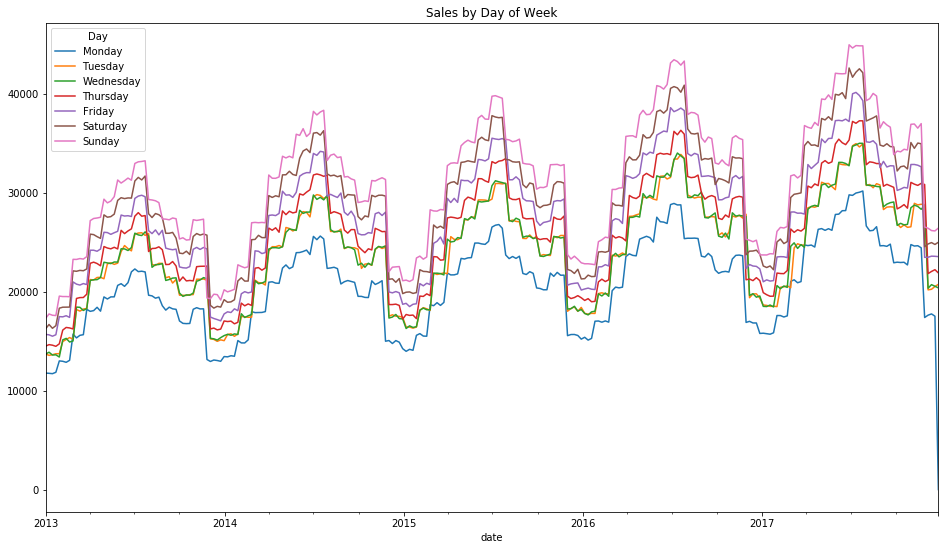

In [37]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

### Day of Week Conclusion
Day of week does impact sales, however all stores & items have similar distributions. Day of week trends follow general weekly trend.

## Findings and Steps Forward
Items and stores weekly sales have seasonality and can be munged into a stationary dataset. They also have similar day of week variability, and items have roughly same distributions in stores.

### Modeling Process
Split the data into train and test data (3 months of test). Will compare several models, all of which are outlined below. The goal is to find the model with the best accuracy.
#### Model (1.1)
+ Dynamic Time Warping (DTW) on item *__weekly__* sales to cluster to nearest 10% quartile
+ Forecast with *__ARIMA__*
+ Percentages will be used to find item sales by store by day

#### Model (1.2)
+ Forecast weekly item sales with *__ARIMA__*
+ Percentages will be used to find item sales by store by day

#### Model (2)
+ Item *__daily__* sales with added features:
 + Day of year (in mod 364)
 + Day of Quarter (in mod 91)
 + Quarter (in mod 4)
 + Day of week (binary columns)
 + Month
 + Prior year sales
 + Average sales by item by store by day of year
 + Average sales by item by store by day of week by quarter
 + Whether or not a weekend (Fri-Sun)
 + Dynamic Time Warping (DTW) on item weekly sales to cluster to nearest 10% quartile
+ Forecast with *__feed forward neural network__*

#### Model (3)
+ Item *__daily__* sales with added features:
 + Day of year (in mod 364)
 + Day of Quarter (in mod 91)
 + Quarter (in mod 4)
 + Day of week (binary columns)
 + Month
 + Prior year sales
 + Average sales by item by store by day of year
 + Average sales by item by store by day of week by quarter
 + Whether or not a weekend (Fri-Sun)
 + Dynamic Time Warping (DTW) on item weekly sales to cluster to nearest 10% quartile
+ Forecast with *__xgboost__*

# ARIMA Models
## Model (1.1) - Clustered Weekly Data

NOTE: Most of the ARIMA model code is commented due to Kaggle only allowing one custom library. Error results are reported at the end of each model.

Will be using the 10% quartile weekly item sales that was created during the exploratory analysis. Since the competition is predicting the next 3 months of sales, we will use 3 months (13 weeks) of test data.

We will build an ARIMA model for each quartile then use clustering and percentages to arrive at daily items sales by store.

In [38]:
train = item_WK_qtr[:-13]
test = df.loc[df.index >= pd.to_datetime('October 3, 2017')] # last 13 weeks of data

In [39]:
store_pct = store_item.transpose()
store_pct

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,9.085564,9.073791,9.062798,9.066774,9.049011,9.069617,9.018065,9.028203,9.049435,9.061402,...,9.091271,9.023547,9.015145,9.046201,9.024192,9.011790,9.005155,9.063957,9.020410,9.007414
2,12.816904,12.858324,12.824640,12.828092,12.822540,12.810300,12.823723,12.877231,12.741440,12.850031,...,12.757648,12.910997,12.825060,12.853127,12.828966,12.827383,12.810710,12.857803,12.855471,12.844459
3,11.405039,11.405115,11.399713,11.411098,11.361155,11.453447,11.386753,11.373289,11.381009,11.387498,...,11.357555,11.392619,11.345828,11.356511,11.398149,11.382714,11.416667,11.430911,11.337725,11.377637
4,10.435394,10.536256,10.520157,10.488994,10.635385,10.472900,10.528670,10.502894,10.516433,10.521691,...,10.529945,10.504758,10.531103,10.528659,10.509172,10.474110,10.504977,10.469840,10.513140,10.461351
5,7.615152,7.595244,7.596620,7.622161,7.672941,7.617378,7.608884,7.610874,7.557394,7.580473,...,7.649611,7.558458,7.634991,7.624657,7.622733,7.628759,7.589458,7.649330,7.626250,7.637765
6,7.605435,7.603005,7.589895,7.611960,7.567640,7.606987,7.619737,7.587459,7.678561,7.588026,...,7.548057,7.602791,7.609901,7.593175,7.587462,7.595511,7.593689,7.604753,7.561284,7.667690
7,6.896388,6.951524,6.967704,6.977734,6.936133,6.957439,6.955239,6.981670,6.986196,6.985992,...,7.031828,6.933015,6.906426,6.954962,6.937566,6.962599,7.034927,6.937165,6.956239,6.955393
8,12.275527,12.233490,12.301689,12.243629,12.216389,12.299760,12.255129,12.275640,12.296844,12.265646,...,12.287964,12.304810,12.278209,12.311782,12.278019,12.279176,12.339060,12.216875,12.283843,12.290432
9,10.611534,10.549439,10.516570,10.517856,10.497569,10.497144,10.560575,10.563672,10.528475,10.529543,...,10.540399,10.532970,10.557261,10.534061,10.559598,10.574879,10.454452,10.511004,10.585387,10.520038


#### Dynamic Time Warping to 10% Quartiles
Matches each item to nearest 10% quartile. Outputs list of item id, % quartile /10, and dtw score.

In [40]:
fitted_items_WK = []
qtr_list = [0] *11

for column in items:
    for c in range(11):
        qtr_list[c] = [fdt.fastdtw(items[column],item_WK_qtr.iloc[:,c], dist= euclidean)[0], c]
    qtr_list.sort()
    fitted_items_WK.append([column[1], qtr_list[0][1], qtr_list[0][0]])

#### Fitting Models and Forecasting

In [62]:
ARIMA_predictions = pd.DataFrame()

for column in item_WK_qtr:
    model = ARIMA(item_WK_qtr[column], 52, 52, 52)
    model.fit(train[column])
    ARIMA_predictions[column] = model.predict(n_periods=13)

TypeError: cannot unpack non-iterable int object

In [ ]:
"""item_WK_predictions = pd.DataFrame()

for i in range(50):
    item_WK_predictions[fitted_items_WK[i][0]] = ARIMA_predictions.iloc[:,fitted_items_WK[i][1]]

item_WK_predictions.head()"""

#### Convert Item Weekly Predictions to Daily Predictions
Use day of week percentages from before to calculate daily item sales.

In [ ]:
"""item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()"""

#### Split Predictions by Store
Reshape the store_item DataFrame and use percentages to calculate daily item sales by store.

In [ ]:
"""store_item = pd.DataFrame(store_item.stack()).reset_index()
store_item.columns = ['item','store','pct']

item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100"""

In [ ]:
"""item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]

item_Day_fcst.head()"""

#### Convert Week Number and Day of Week into Datetime
Based on where the data was split for testing, the weeks start on Tuesdays so there's no offset then. This adds an additional day of data that we'll need to cutoff.

This is needed so we can remove the additional day in a readable way.

In [ ]:
"""def str_to_date(row):"""
    """Takes day of week string and week offset to calculate date"""
    """switcher = {
        'Tuesday': 0, #data starts on a Tuesday, so 0 offset
        'Wednesday': 1,
        'Thursday': 2,
        'Friday': 3,
        'Saturday': 4,
        'Sunday': 5,
        'Monday': 6
    }
    weeks = pd.to_timedelta(7* row['Week #'], unit='D')
    days = pd.to_timedelta(switcher.get(row['Day']), unit='D')
    
    return pd.to_datetime('October 3, 2017') + weeks + days


item_Day_fcst['Date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['Date']"""

In [ ]:
"""item_Day_fcst.sort_values(['item','store','Date'], inplace=True)
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[
    item_Day_fcst.index < pd.to_datetime('January 1, 2018')]"""

#### Model Accuracy
The predictions have been organized the same as the testing data, so we can simply plug both into our error function.

From this model we get 19.49% error.

In [ ]:
"""SMAPE(item_Day_fcst['sales'], test['sales'])"""

## Model (1.2) - Unclustered Weekly Data

Now that we've forecasted item quartiles, let's forecast for each item separately. This is to see if there's a difference in accuracy.

We will build an ARIMA model for each item then use percentages to arrive at daily items sales by store.

In [ ]:
train = items['sales'][:-13]

#### Fitting Models and Forecasting

In [ ]:
"""item_WK_predictions = pd.DataFrame()

for column in items['sales']:
    model = ARIMA(items['sales'][column], 52, 52, 52)
    model.fit(train[column])
    item_WK_predictions[column] = model.predict(n_periods=13)"""

#### Convert Item Weekly Predictions to Daily Predictions
Using day of week percentages from before.

In [ ]:
"""item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()"""

#### Split Predictions by Store
Reshape the store_item DataFrame and use percentages.

In [ ]:
"""item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100"""

In [ ]:
"""item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]"""

#### Convert Week Number and Day of Week into Datetime

In [ ]:
"""item_Day_fcst['Date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['Date']"""

In [ ]:
"""item_Day_fcst.sort_values(['item','store','Date'], inplace=True)
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[
    item_Day_fcst.index < pd.to_datetime('January 1, 2018')]"""

#### Model Accuracy

We get 19.60% error.

In [ ]:
"""SMAPE(item_Day_fcst['sales'], test['sales'])"""

# DNN Model
## Model (2) - Feed Forward Neural Network with Daily Data

To really take advantage of the DNN, we need to add features. We won't be adding any rolling/ expanding windows since they'd be unreliable on the competition data. Most of the engineered features are categorical, with the exception being prior year sales.

Below are some constants we'll need to use for working with datetimes.

In [42]:
ns_per_day = 86400000000000
start_date = pd.to_datetime('January 1, 2013')

### Feature Engineering
**Day of Week**
 + Utilizing pandas builtin dayofweek call to create binary columns for each day of week.

**Month**
 + Utilizing pandas buitlin month call.
 
**Day of Year**
 + Take the number of days since the data started, then take (mod 364) for a like-for-like day of year.
 + Want to do this instead of calendar day of year because the dates land on different days of the week. Example: January 1 might be a Tuesday one year so it'll be a Wednesday next year.
 
**Day of Quarter**
 + Take the number of days since the data started, then take the quotient when divided by 91 and put into (mod 4).
 + This is to give us similar quarters, same reasoning as above.
 
**Day Number**
  + Number of days since start of train data.
 
**Quarter**
 + Take the number of days since the data started, then take the quotient when divided by 91.
 + This is to give us similar quarters.
 
**Is Weekend**
 + Boolean value if the date falls on a weekend. This is because a majority of sales occur between Friday and Sunday.
 
**Item Quart**
 + Which quartile trend the item most closely resembles. This comes from the dynamic time warping we had done for the ARIMA models.
 
**12 Month Lag**
 + Prior year's sales (same store, same item, 364 days prior).

**Averages**
 + Averages by item by store for:
  + Day of Week by Quarter
  + Day of Year

In [43]:
itm_quart = pd.DataFrame(fitted_items_WK, columns=['item','item_quart','item_metric'])

def add_feat(df, train_end_str):
    """Adds Features to DataFrame and Takes Averages for Dates Before train_end_str"""
    
    dataf = df
    
    dataf['Weekday'] = dataf.index.dayofweek
    dataf['Is_Mon'] = (dataf.index.dayofweek == 0) *1
    dataf['Is_Tue'] = (dataf.index.dayofweek == 1) *1
    dataf['Is_Wed'] = (dataf.index.dayofweek == 2) *1
    dataf['Is_Thu'] = (dataf.index.dayofweek == 3) *1
    dataf['Is_Fri'] = (dataf.index.dayofweek == 4) *1
    dataf['Is_Sat'] = (dataf.index.dayofweek == 5) *1
    dataf['Is_Sun'] = (dataf.index.dayofweek == 6) *1
    dataf['Is_wknd'] = dataf.index.dayofweek // 4 # Fri-Sun are 4-6, Monday is 0 so this is valid
    dataf['Day_Num'] = ((dataf.index - start_date)/ ns_per_day).astype(int)
    
    dataf['Month'] = dataf.index.month
    dataf['Day_of_Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 364
    dataf['Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) // 364 -1
    dataf['Day_of_Quarter'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 91
    dataf['Quarter'] = (((dataf.index - start_date)/ ns_per_day).astype(int) // 91) % 4
    dataf.reset_index(inplace=True)
    
    # Add item quartile as feature
    dataf = dataf.merge(itm_quart, on='item').drop('item_metric', axis=1)

    # Add prior year sales as additional feature
    prior_year_sales = dataf[['date','sales','store','item']]
    prior_year_sales['date'] += pd.Timedelta('364 days')
    prior_year_sales.columns =['date','lag_12mo','store','item']

    dataf = dataf.merge(prior_year_sales, on=['date','store','item'])
    
    # Add average by item by store by day of year as additional feature
    avg = dataf.loc[df['date'] < pd.to_datetime(train_end_str), ['Day_of_Year','sales','store','item']].groupby(by=['Day_of_Year','store','item']).mean().reset_index()
    avg.columns =['Day_of_Year','store','item','DoY_Mean']
    
    dataf = dataf.merge(avg, on=['Day_of_Year','store','item'])
    
    # Add average by day of week by quarter by item by store as additional feature
    avg = dataf.loc[df['date'] < pd.to_datetime(train_end_str), ['Quarter','Weekday','sales','store','item']].groupby(by=['Quarter','Weekday','store','item']).mean().reset_index()
    avg.columns =['Quarter','Weekday','store','item','DoW_Mean']
    
    dataf = dataf.merge(avg, on=['Quarter','Weekday','store','item'])
    
    # Id's start at 0 instead of 1
    dataf['store'] -=1
    dataf['item'] -=1
    
    # Remove first year of data as there is no prior year sales for them, then sort to match competition id's
    dataf = dataf[dataf['Year'] >=0].drop('Year', axis=1).sort_values(['item','store','date'])
    
    return dataf

In [44]:
df_test = add_feat(df, 'October 3, 2017') # Takes average of training data

df_test.tail(10)

C:\Users\amols\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,store,item,sales,Day,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,...,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
730843,2017-12-22,9,49,75,Friday,4,0,0,0,0,...,1,1816,12,360,87,3,7,64,63.0,74.884615
730895,2017-12-23,9,49,70,Saturday,5,0,0,0,0,...,1,1817,12,361,88,3,7,65,69.0,81.980769
730947,2017-12-24,9,49,76,Sunday,6,0,0,0,0,...,1,1818,12,362,89,3,7,64,66.0,85.634615
730999,2017-12-25,9,49,51,Monday,0,1,0,0,0,...,0,1819,12,363,90,3,7,61,47.0,59.230769
729542,2017-12-26,9,49,41,Tuesday,1,0,1,0,0,...,0,1820,12,0,0,0,7,60,47.4,53.037736
729595,2017-12-27,9,49,63,Wednesday,2,0,0,1,0,...,0,1821,12,1,1,0,7,43,46.8,54.924528
729648,2017-12-28,9,49,59,Thursday,3,0,0,0,1,...,0,1822,12,2,2,0,7,68,54.6,59.943396
729701,2017-12-29,9,49,74,Friday,4,0,0,0,0,...,1,1823,12,3,3,0,7,63,60.0,64.075472
729754,2017-12-30,9,49,62,Saturday,5,0,0,0,0,...,1,1824,12,4,4,0,7,64,59.2,67.603774
729807,2017-12-31,9,49,82,Sunday,6,0,0,0,0,...,1,1825,12,5,5,0,7,69,69.6,70.811321


In [45]:
df_test.head(10)

,date,store,item,sales,Day,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,...,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
0,2013-12-31,0,0,15,Tuesday,1,0,1,0,0,...,0,364,12,0,0,0,1,13,12.80,13.735849
53,2014-01-01,0,0,9,Wednesday,2,0,0,1,0,...,0,365,1,1,1,0,1,11,13.20,16.132075
106,2014-01-02,0,0,14,Thursday,3,0,0,0,1,...,0,366,1,2,2,0,1,14,16.60,15.943396
159,2014-01-03,0,0,11,Friday,4,0,0,0,0,...,1,367,1,3,3,0,1,13,18.00,17.075472
212,2014-01-04,0,0,20,Saturday,5,0,0,0,0,...,1,368,1,4,4,0,1,10,18.00,17.283019
265,2014-01-05,0,0,17,Sunday,6,0,0,0,0,...,1,369,1,5,5,0,1,12,17.00,19.603774
318,2014-01-06,0,0,14,Monday,0,1,0,0,0,...,0,370,1,6,6,0,1,10,13.75,12.538462
5,2014-01-07,0,0,11,Tuesday,1,0,1,0,0,...,0,371,1,7,7,0,1,9,10.50,13.735849
58,2014-01-08,0,0,12,Wednesday,2,0,0,1,0,...,0,372,1,8,8,0,1,12,14.25,16.132075
111,2014-01-09,0,0,17,Thursday,3,0,0,0,1,...,0,373,1,9,9,0,1,9,15.25,15.943396


### Train & Test Data Split
Split train and test data by setting the last 91 days (everything after October 3, 2017) as test data.

In [46]:
x_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017')].drop(['sales','date','Day', 'Weekday'], axis=1)
y_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017'), 'sales']

x_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017')].drop(['sales','date','Day', 'Weekday'], axis=1).reset_index(drop=True)
y_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].reset_index(drop=True)

### Feature Columns
Setup the feature colunms in the tensorflow model. Most of the features are categorical, the only numeric one is 'lag_12mo'

In [47]:
feat_cols =[]

for col in x_train.drop(['lag_12mo','DoW_Mean','DoY_Mean'], axis=1).columns:
    feat_cols.append(tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_identity(col, max(df_test[col])+1),1))
    
feat_cols.append(tf.feature_column.numeric_column(key='lag_12mo'))
feat_cols.append(tf.feature_column.numeric_column(key='DoY_Mean'))
feat_cols.append(tf.feature_column.numeric_column(key='DoW_Mean'))

### Training the Model & Forecasting
Setup the training (input) function in tensorflow. Sending 6 months (180 days) of data to train on at once and will run through the entire dataset 80 times. We won't shuffle the observations for this exercise. Idea being that the order of observations matters since this is a time series.

In [49]:
input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x= x_train, y= y_train, batch_size= 180, num_epochs= 80,
                                                 shuffle= False)

The model we'll use is tensorflow's builtin DNNRegressor with 3 hidden layers.

In [50]:
regressor = tf.estimator.DNNRegressor(hidden_units= [20, 10, 20], feature_columns= feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\amols\\AppData\\Local\\Temp\\tmp9w7qlwdj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000015C10859608>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [51]:
regressor.train(input_fn= input_func)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:

INFO:tensorflow:loss = 225.369, step = 4800 (0.342 sec)
INFO:tensorflow:global_step/sec: 281.661
INFO:tensorflow:loss = 66.45744, step = 4900 (0.353 sec)
INFO:tensorflow:global_step/sec: 303.928
INFO:tensorflow:loss = 145.57971, step = 5000 (0.331 sec)
INFO:tensorflow:global_step/sec: 304.044
INFO:tensorflow:loss = 36.441437, step = 5100 (0.329 sec)
INFO:tensorflow:global_step/sec: 299.504
INFO:tensorflow:loss = 115.86789, step = 5200 (0.332 sec)
INFO:tensorflow:global_step/sec: 281.013
INFO:tensorflow:loss = 32.78883, step = 5300 (0.356 sec)
INFO:tensorflow:global_step/sec: 296.397
INFO:tensorflow:loss = 55.840202, step = 5400 (0.337 sec)
INFO:tensorflow:global_step/sec: 261.867
INFO:tensorflow:loss = 135.9598, step = 5500 (0.384 sec)
INFO:tensorflow:global_step/sec: 252.097
INFO:tensorflow:loss = 27.442535, step = 5600 (0.396 sec)
INFO:tensorflow:global_step/sec: 265.434
INFO:tensorflow:loss = 90.5851, step = 5700 (0.379 sec)
INFO:tensorflow:global_step/sec: 279.484
INFO:tensorflow:l

INFO:tensorflow:loss = 36.380817, step = 13100 (0.398 sec)
INFO:tensorflow:global_step/sec: 226.164
INFO:tensorflow:loss = 50.262142, step = 13200 (0.442 sec)
INFO:tensorflow:global_step/sec: 230.127
INFO:tensorflow:loss = 35.009575, step = 13300 (0.438 sec)
INFO:tensorflow:global_step/sec: 250.491
INFO:tensorflow:loss = 65.18225, step = 13400 (0.396 sec)
INFO:tensorflow:global_step/sec: 255.306
INFO:tensorflow:loss = 127.98998, step = 13500 (0.394 sec)
INFO:tensorflow:global_step/sec: 259.262
INFO:tensorflow:loss = 37.644066, step = 13600 (0.383 sec)
INFO:tensorflow:global_step/sec: 231.717
INFO:tensorflow:loss = 77.18318, step = 13700 (0.435 sec)
INFO:tensorflow:global_step/sec: 219.019
INFO:tensorflow:loss = 89.09296, step = 13800 (0.457 sec)
INFO:tensorflow:global_step/sec: 255.304
INFO:tensorflow:loss = 54.22151, step = 13900 (0.390 sec)
INFO:tensorflow:global_step/sec: 248.288
INFO:tensorflow:loss = 62.843365, step = 14000 (0.404 sec)
INFO:tensorflow:global_step/sec: 255.46
INFO:

INFO:tensorflow:global_step/sec: 247.075
INFO:tensorflow:loss = 137.892, step = 21400 (0.405 sec)
INFO:tensorflow:global_step/sec: 247.738
INFO:tensorflow:loss = 69.8917, step = 21500 (0.404 sec)
INFO:tensorflow:global_step/sec: 253.983
INFO:tensorflow:loss = 55.37234, step = 21600 (0.391 sec)
INFO:tensorflow:global_step/sec: 226.496
INFO:tensorflow:loss = 41.993355, step = 21700 (0.442 sec)
INFO:tensorflow:global_step/sec: 233.604
INFO:tensorflow:loss = 78.409904, step = 21800 (0.431 sec)
INFO:tensorflow:global_step/sec: 228.002
INFO:tensorflow:loss = 15.5858, step = 21900 (0.438 sec)
INFO:tensorflow:global_step/sec: 247.13
INFO:tensorflow:loss = 104.43131, step = 22000 (0.406 sec)
INFO:tensorflow:global_step/sec: 230.647
INFO:tensorflow:loss = 44.09039, step = 22100 (0.433 sec)
INFO:tensorflow:global_step/sec: 248.193
INFO:tensorflow:loss = 95.93611, step = 22200 (0.404 sec)
INFO:tensorflow:global_step/sec: 241.77
INFO:tensorflow:loss = 73.55241, step = 22300 (0.413 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 223.708
INFO:tensorflow:loss = 54.101254, step = 29700 (0.448 sec)
INFO:tensorflow:global_step/sec: 259.263
INFO:tensorflow:loss = 85.25177, step = 29800 (0.387 sec)
INFO:tensorflow:global_step/sec: 250.836
INFO:tensorflow:loss = 194.86784, step = 29900 (0.397 sec)
INFO:tensorflow:global_step/sec: 247.997
INFO:tensorflow:loss = 43.175694, step = 30000 (0.414 sec)
INFO:tensorflow:global_step/sec: 237.039
INFO:tensorflow:loss = 39.00042, step = 30100 (0.412 sec)
INFO:tensorflow:global_step/sec: 245.897
INFO:tensorflow:loss = 43.720707, step = 30200 (0.407 sec)
INFO:tensorflow:global_step/sec: 243.313
INFO:tensorflow:loss = 57.013798, step = 30300 (0.410 sec)
INFO:tensorflow:global_step/sec: 252.821
INFO:tensorflow:loss = 19.967628, step = 30400 (0.396 sec)
INFO:tensorflow:global_step/sec: 244.457
INFO:tensorflow:loss = 100.627884, step = 30500 (0.411 sec)
INFO:tensorflow:global_step/sec: 246.054
INFO:tensorflow:loss = 27.72808, step = 30600 (0.404 sec)
IN

INFO:tensorflow:loss = 36.453617, step = 37900 (0.456 sec)
INFO:tensorflow:global_step/sec: 234.373
INFO:tensorflow:loss = 73.8719, step = 38000 (0.412 sec)
INFO:tensorflow:global_step/sec: 241.187
INFO:tensorflow:loss = 42.76156, step = 38100 (0.418 sec)
INFO:tensorflow:global_step/sec: 221.49
INFO:tensorflow:loss = 58.155956, step = 38200 (0.450 sec)
INFO:tensorflow:global_step/sec: 248.601
INFO:tensorflow:loss = 86.629944, step = 38300 (0.402 sec)
INFO:tensorflow:global_step/sec: 236.3
INFO:tensorflow:loss = 72.03808, step = 38400 (0.424 sec)
INFO:tensorflow:global_step/sec: 224.462
INFO:tensorflow:loss = 23.80548, step = 38500 (0.444 sec)
INFO:tensorflow:global_step/sec: 223.916
INFO:tensorflow:loss = 87.607994, step = 38600 (0.449 sec)
INFO:tensorflow:global_step/sec: 202.098
INFO:tensorflow:loss = 100.87868, step = 38700 (0.491 sec)
INFO:tensorflow:global_step/sec: 218.229
INFO:tensorflow:loss = 27.731382, step = 38800 (0.461 sec)
INFO:tensorflow:global_step/sec: 236.794
INFO:ten

INFO:tensorflow:global_step/sec: 234.715
INFO:tensorflow:loss = 36.01592, step = 46200 (0.425 sec)
INFO:tensorflow:global_step/sec: 230.654
INFO:tensorflow:loss = 51.404602, step = 46300 (0.436 sec)
INFO:tensorflow:global_step/sec: 242.354
INFO:tensorflow:loss = 29.85403, step = 46400 (0.413 sec)
INFO:tensorflow:global_step/sec: 229.809
INFO:tensorflow:loss = 72.294975, step = 46500 (0.435 sec)
INFO:tensorflow:global_step/sec: 232.796
INFO:tensorflow:loss = 19.846937, step = 46600 (0.430 sec)
INFO:tensorflow:global_step/sec: 236.637
INFO:tensorflow:loss = 19.172838, step = 46700 (0.422 sec)
INFO:tensorflow:global_step/sec: 242.137
INFO:tensorflow:loss = 65.42519, step = 46800 (0.428 sec)
INFO:tensorflow:global_step/sec: 224.135
INFO:tensorflow:loss = 98.59594, step = 46900 (0.430 sec)
INFO:tensorflow:global_step/sec: 233.881
INFO:tensorflow:loss = 35.16292, step = 47000 (0.430 sec)
INFO:tensorflow:global_step/sec: 236.837
INFO:tensorflow:loss = 83.0639, step = 47100 (0.422 sec)
INFO:te

INFO:tensorflow:global_step/sec: 183.764
INFO:tensorflow:loss = 91.229515, step = 54500 (0.543 sec)
INFO:tensorflow:global_step/sec: 209.245
INFO:tensorflow:loss = 76.46572, step = 54600 (0.481 sec)
INFO:tensorflow:global_step/sec: 194.071
INFO:tensorflow:loss = 56.965046, step = 54700 (0.515 sec)
INFO:tensorflow:global_step/sec: 207.983
INFO:tensorflow:loss = 61.044468, step = 54800 (0.481 sec)
INFO:tensorflow:global_step/sec: 204.372
INFO:tensorflow:loss = 87.37638, step = 54900 (0.487 sec)
INFO:tensorflow:global_step/sec: 210.346
INFO:tensorflow:loss = 143.93578, step = 55000 (0.477 sec)
INFO:tensorflow:global_step/sec: 217.174
INFO:tensorflow:loss = 44.171, step = 55100 (0.460 sec)
INFO:tensorflow:global_step/sec: 211.002
INFO:tensorflow:loss = 111.611824, step = 55200 (0.474 sec)
INFO:tensorflow:global_step/sec: 175.098
INFO:tensorflow:loss = 50.192844, step = 55300 (0.569 sec)
INFO:tensorflow:global_step/sec: 199.472
INFO:tensorflow:loss = 67.54343, step = 55400 (0.503 sec)
INFO:

INFO:tensorflow:loss = 86.28156, step = 62700 (0.432 sec)
INFO:tensorflow:global_step/sec: 234.972
INFO:tensorflow:loss = 71.478386, step = 62800 (0.425 sec)
INFO:tensorflow:global_step/sec: 231.71
INFO:tensorflow:loss = 90.88378, step = 62900 (0.433 sec)
INFO:tensorflow:global_step/sec: 233.164
INFO:tensorflow:loss = 23.489552, step = 63000 (0.429 sec)
INFO:tensorflow:global_step/sec: 229.598
INFO:tensorflow:loss = 135.33931, step = 63100 (0.436 sec)
INFO:tensorflow:global_step/sec: 233.3
INFO:tensorflow:loss = 29.14919, step = 63200 (0.428 sec)
INFO:tensorflow:global_step/sec: 229.479
INFO:tensorflow:loss = 63.189957, step = 63300 (0.437 sec)
INFO:tensorflow:global_step/sec: 221.003
INFO:tensorflow:loss = 106.23468, step = 63400 (0.450 sec)
INFO:tensorflow:global_step/sec: 210.47
INFO:tensorflow:loss = 26.239697, step = 63500 (0.477 sec)
INFO:tensorflow:global_step/sec: 210.562
INFO:tensorflow:loss = 51.581184, step = 63600 (0.473 sec)
INFO:tensorflow:global_step/sec: 177.898
INFO:te

INFO:tensorflow:global_step/sec: 214.99
INFO:tensorflow:loss = 42.84293, step = 71000 (0.468 sec)
INFO:tensorflow:global_step/sec: 218.124
INFO:tensorflow:loss = 60.203403, step = 71100 (0.456 sec)
INFO:tensorflow:global_step/sec: 237.756
INFO:tensorflow:loss = 27.603743, step = 71200 (0.423 sec)
INFO:tensorflow:global_step/sec: 215.313
INFO:tensorflow:loss = 103.16454, step = 71300 (0.461 sec)
INFO:tensorflow:global_step/sec: 224.965
INFO:tensorflow:loss = 58.528053, step = 71400 (0.446 sec)
INFO:tensorflow:global_step/sec: 239.157
INFO:tensorflow:loss = 52.606625, step = 71500 (0.419 sec)
INFO:tensorflow:global_step/sec: 227.003
INFO:tensorflow:loss = 179.56076, step = 71600 (0.442 sec)
INFO:tensorflow:global_step/sec: 188.599
INFO:tensorflow:loss = 71.652245, step = 71700 (0.527 sec)
INFO:tensorflow:global_step/sec: 196.916
INFO:tensorflow:loss = 71.32049, step = 71800 (0.512 sec)
INFO:tensorflow:global_step/sec: 212.572
INFO:tensorflow:loss = 58.477757, step = 71900 (0.469 sec)
INF

INFO:tensorflow:loss = 34.423298, step = 79200 (0.424 sec)
INFO:tensorflow:global_step/sec: 235.733
INFO:tensorflow:loss = 23.656282, step = 79300 (0.422 sec)
INFO:tensorflow:global_step/sec: 229.071
INFO:tensorflow:loss = 88.51666, step = 79400 (0.439 sec)
INFO:tensorflow:global_step/sec: 228.554
INFO:tensorflow:loss = 29.522114, step = 79500 (0.438 sec)
INFO:tensorflow:global_step/sec: 179.319
INFO:tensorflow:loss = 98.65766, step = 79600 (0.555 sec)
INFO:tensorflow:global_step/sec: 233.859
INFO:tensorflow:loss = 93.54158, step = 79700 (0.430 sec)
INFO:tensorflow:global_step/sec: 240.035
INFO:tensorflow:loss = 36.36016, step = 79800 (0.417 sec)
INFO:tensorflow:global_step/sec: 212.771
INFO:tensorflow:loss = 46.999374, step = 79900 (0.468 sec)
INFO:tensorflow:global_step/sec: 213.483
INFO:tensorflow:loss = 93.89389, step = 80000 (0.469 sec)
INFO:tensorflow:global_step/sec: 211.229
INFO:tensorflow:loss = 98.21186, step = 80100 (0.474 sec)
INFO:tensorflow:global_step/sec: 209.679
INFO:t

INFO:tensorflow:global_step/sec: 251.434
INFO:tensorflow:loss = 28.507946, step = 87500 (0.396 sec)
INFO:tensorflow:global_step/sec: 250.481
INFO:tensorflow:loss = 84.38408, step = 87600 (0.399 sec)
INFO:tensorflow:global_step/sec: 247.026
INFO:tensorflow:loss = 73.832825, step = 87700 (0.407 sec)
INFO:tensorflow:global_step/sec: 246.481
INFO:tensorflow:loss = 40.517807, step = 87800 (0.404 sec)
INFO:tensorflow:global_step/sec: 249.505
INFO:tensorflow:loss = 58.2838, step = 87900 (0.401 sec)
INFO:tensorflow:global_step/sec: 238.746
INFO:tensorflow:loss = 24.714067, step = 88000 (0.421 sec)
INFO:tensorflow:global_step/sec: 233.921
INFO:tensorflow:loss = 22.870382, step = 88100 (0.426 sec)
INFO:tensorflow:global_step/sec: 229.068
INFO:tensorflow:loss = 77.98311, step = 88200 (0.437 sec)
INFO:tensorflow:global_step/sec: 238.334
INFO:tensorflow:loss = 30.236002, step = 88300 (0.419 sec)
INFO:tensorflow:global_step/sec: 211.886
INFO:tensorflow:loss = 102.819496, step = 88400 (0.472 sec)
INF

INFO:tensorflow:loss = 50.467323, step = 95700 (0.432 sec)
INFO:tensorflow:global_step/sec: 229.431
INFO:tensorflow:loss = 20.631472, step = 95800 (0.436 sec)
INFO:tensorflow:global_step/sec: 221.732
INFO:tensorflow:loss = 33.18296, step = 95900 (0.449 sec)
INFO:tensorflow:global_step/sec: 229.747
INFO:tensorflow:loss = 41.450237, step = 96000 (0.434 sec)
INFO:tensorflow:global_step/sec: 228.342
INFO:tensorflow:loss = 89.14622, step = 96100 (0.438 sec)
INFO:tensorflow:global_step/sec: 245.227
INFO:tensorflow:loss = 79.37737, step = 96200 (0.410 sec)
INFO:tensorflow:global_step/sec: 234.977
INFO:tensorflow:loss = 62.228935, step = 96300 (0.427 sec)
INFO:tensorflow:global_step/sec: 231.968
INFO:tensorflow:loss = 22.557335, step = 96400 (0.429 sec)
INFO:tensorflow:global_step/sec: 241.655
INFO:tensorflow:loss = 48.27332, step = 96500 (0.414 sec)
INFO:tensorflow:global_step/sec: 245.921
INFO:tensorflow:loss = 24.997236, step = 96600 (0.408 sec)
INFO:tensorflow:global_step/sec: 241.054
INFO

INFO:tensorflow:loss = 49.077175, step = 103900 (0.521 sec)
INFO:tensorflow:global_step/sec: 218.382
INFO:tensorflow:loss = 32.554337, step = 104000 (0.462 sec)
INFO:tensorflow:global_step/sec: 236.62
INFO:tensorflow:loss = 33.160873, step = 104100 (0.422 sec)
INFO:tensorflow:global_step/sec: 217.189
INFO:tensorflow:loss = 76.52131, step = 104200 (0.461 sec)
INFO:tensorflow:global_step/sec: 209.863
INFO:tensorflow:loss = 12.159327, step = 104300 (0.476 sec)
INFO:tensorflow:global_step/sec: 213.473
INFO:tensorflow:loss = 57.454346, step = 104400 (0.467 sec)
INFO:tensorflow:global_step/sec: 217.376
INFO:tensorflow:loss = 31.449455, step = 104500 (0.462 sec)
INFO:tensorflow:global_step/sec: 224.355
INFO:tensorflow:loss = 13.319901, step = 104600 (0.445 sec)
INFO:tensorflow:global_step/sec: 235.579
INFO:tensorflow:loss = 55.744305, step = 104700 (0.425 sec)
INFO:tensorflow:global_step/sec: 225.204
INFO:tensorflow:loss = 125.882675, step = 104800 (0.444 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 220.531
INFO:tensorflow:loss = 41.75619, step = 112100 (0.453 sec)
INFO:tensorflow:global_step/sec: 217.433
INFO:tensorflow:loss = 38.887905, step = 112200 (0.460 sec)
INFO:tensorflow:global_step/sec: 219.094
INFO:tensorflow:loss = 20.074352, step = 112300 (0.456 sec)
INFO:tensorflow:global_step/sec: 216.911
INFO:tensorflow:loss = 49.69892, step = 112400 (0.461 sec)
INFO:tensorflow:global_step/sec: 218.744
INFO:tensorflow:loss = 62.7444, step = 112500 (0.458 sec)
INFO:tensorflow:global_step/sec: 215.31
INFO:tensorflow:loss = 68.85418, step = 112600 (0.463 sec)
INFO:tensorflow:global_step/sec: 228.233
INFO:tensorflow:loss = 50.83085, step = 112700 (0.436 sec)
INFO:tensorflow:global_step/sec: 191.978
INFO:tensorflow:loss = 98.142555, step = 112800 (0.521 sec)
INFO:tensorflow:global_step/sec: 185.729
INFO:tensorflow:loss = 94.27809, step = 112900 (0.538 sec)
INFO:tensorflow:global_step/sec: 187.748
INFO:tensorflow:loss = 82.33019, step = 113000 (0.534 sec)

INFO:tensorflow:global_step/sec: 217.824
INFO:tensorflow:loss = 89.19594, step = 120300 (0.458 sec)
INFO:tensorflow:global_step/sec: 227.007
INFO:tensorflow:loss = 137.01178, step = 120400 (0.441 sec)
INFO:tensorflow:global_step/sec: 223.332
INFO:tensorflow:loss = 65.465324, step = 120500 (0.448 sec)
INFO:tensorflow:global_step/sec: 226.662
INFO:tensorflow:loss = 86.58809, step = 120600 (0.441 sec)
INFO:tensorflow:global_step/sec: 222.434
INFO:tensorflow:loss = 50.95189, step = 120700 (0.448 sec)
INFO:tensorflow:global_step/sec: 228.522
INFO:tensorflow:loss = 102.1432, step = 120800 (0.439 sec)
INFO:tensorflow:global_step/sec: 206.401
INFO:tensorflow:loss = 18.225111, step = 120900 (0.485 sec)
INFO:tensorflow:global_step/sec: 184.438
INFO:tensorflow:loss = 39.019054, step = 121000 (0.539 sec)
INFO:tensorflow:global_step/sec: 209.464
INFO:tensorflow:loss = 36.482845, step = 121100 (0.477 sec)
INFO:tensorflow:global_step/sec: 224.21
INFO:tensorflow:loss = 33.805355, step = 121200 (0.448 

INFO:tensorflow:global_step/sec: 236.318
INFO:tensorflow:loss = 98.4145, step = 128500 (0.423 sec)
INFO:tensorflow:global_step/sec: 242.942
INFO:tensorflow:loss = 20.22806, step = 128600 (0.412 sec)
INFO:tensorflow:global_step/sec: 243.531
INFO:tensorflow:loss = 24.05066, step = 128700 (0.410 sec)
INFO:tensorflow:global_step/sec: 249.589
INFO:tensorflow:loss = 134.96306, step = 128800 (0.402 sec)
INFO:tensorflow:global_step/sec: 247.129
INFO:tensorflow:loss = 75.54877, step = 128900 (0.405 sec)
INFO:tensorflow:global_step/sec: 241.166
INFO:tensorflow:loss = 27.647139, step = 129000 (0.414 sec)
INFO:tensorflow:global_step/sec: 244.741
INFO:tensorflow:loss = 108.33322, step = 129100 (0.410 sec)
INFO:tensorflow:global_step/sec: 242.979
INFO:tensorflow:loss = 77.81176, step = 129200 (0.412 sec)
INFO:tensorflow:global_step/sec: 248.35
INFO:tensorflow:loss = 144.95099, step = 129300 (0.401 sec)
INFO:tensorflow:global_step/sec: 251.929
INFO:tensorflow:loss = 44.017876, step = 129400 (0.398 se

INFO:tensorflow:global_step/sec: 266.847
INFO:tensorflow:loss = 49.564953, step = 136700 (0.386 sec)
INFO:tensorflow:global_step/sec: 254.834
INFO:tensorflow:loss = 71.26872, step = 136800 (0.383 sec)
INFO:tensorflow:Saving checkpoints for 136846 into C:\Users\amols\AppData\Local\Temp\tmp9w7qlwdj\model.ckpt.
INFO:tensorflow:global_step/sec: 177.604
INFO:tensorflow:loss = 31.614311, step = 136900 (0.560 sec)
INFO:tensorflow:global_step/sec: 247.038
INFO:tensorflow:loss = 121.76136, step = 137000 (0.407 sec)
INFO:tensorflow:global_step/sec: 244.874
INFO:tensorflow:loss = 40.431248, step = 137100 (0.409 sec)
INFO:tensorflow:global_step/sec: 254.079
INFO:tensorflow:loss = 20.290634, step = 137200 (0.393 sec)
INFO:tensorflow:global_step/sec: 237.138
INFO:tensorflow:loss = 153.31958, step = 137300 (0.422 sec)
INFO:tensorflow:global_step/sec: 250.769
INFO:tensorflow:loss = 63.526867, step = 137400 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.467
INFO:tensorflow:loss = 49.72512, step = 137

INFO:tensorflow:loss = 84.50583, step = 144700 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.143
INFO:tensorflow:loss = 70.385994, step = 144800 (0.398 sec)
INFO:tensorflow:global_step/sec: 246.499
INFO:tensorflow:loss = 14.134965, step = 144900 (0.406 sec)
INFO:tensorflow:global_step/sec: 249.564
INFO:tensorflow:loss = 86.303154, step = 145000 (0.401 sec)
INFO:tensorflow:global_step/sec: 247.264
INFO:tensorflow:loss = 62.751705, step = 145100 (0.403 sec)
INFO:tensorflow:global_step/sec: 251.465
INFO:tensorflow:loss = 102.71593, step = 145200 (0.399 sec)
INFO:tensorflow:global_step/sec: 254.249
INFO:tensorflow:loss = 52.0836, step = 145300 (0.394 sec)
INFO:tensorflow:global_step/sec: 248.967
INFO:tensorflow:loss = 98.58455, step = 145400 (0.402 sec)
INFO:tensorflow:global_step/sec: 251.292
INFO:tensorflow:loss = 91.75347, step = 145500 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.442
INFO:tensorflow:loss = 58.529655, step = 145600 (0.399 sec)
INFO:tensorflow:global_step/sec: 255

INFO:tensorflow:loss = 46.311142, step = 152900 (0.408 sec)
INFO:tensorflow:global_step/sec: 255.715
INFO:tensorflow:loss = 50.340824, step = 153000 (0.389 sec)
INFO:tensorflow:global_step/sec: 242.759
INFO:tensorflow:loss = 71.69383, step = 153100 (0.414 sec)
INFO:tensorflow:global_step/sec: 245.934
INFO:tensorflow:loss = 34.39327, step = 153200 (0.408 sec)
INFO:tensorflow:global_step/sec: 254.655
INFO:tensorflow:loss = 161.69916, step = 153300 (0.393 sec)
INFO:tensorflow:global_step/sec: 254.309
INFO:tensorflow:loss = 20.419884, step = 153400 (0.392 sec)
INFO:tensorflow:global_step/sec: 269.568
INFO:tensorflow:loss = 122.58211, step = 153500 (0.371 sec)
INFO:tensorflow:global_step/sec: 268.671
INFO:tensorflow:loss = 26.980303, step = 153600 (0.372 sec)
INFO:tensorflow:global_step/sec: 274.927
INFO:tensorflow:loss = 23.638435, step = 153700 (0.362 sec)
INFO:tensorflow:global_step/sec: 268.584
INFO:tensorflow:loss = 27.692898, step = 153800 (0.375 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:loss = 42.01497, step = 161100 (0.390 sec)
INFO:tensorflow:global_step/sec: 261.312
INFO:tensorflow:loss = 87.940475, step = 161200 (0.383 sec)
INFO:tensorflow:global_step/sec: 262.657
INFO:tensorflow:loss = 67.246445, step = 161300 (0.382 sec)
INFO:tensorflow:global_step/sec: 256.464
INFO:tensorflow:loss = 20.353106, step = 161400 (0.390 sec)
INFO:tensorflow:global_step/sec: 262.657
INFO:tensorflow:loss = 30.9628, step = 161500 (0.380 sec)
INFO:tensorflow:global_step/sec: 261.97
INFO:tensorflow:loss = 39.220333, step = 161600 (0.380 sec)
INFO:tensorflow:global_step/sec: 260.062
INFO:tensorflow:loss = 39.955997, step = 161700 (0.387 sec)
INFO:tensorflow:global_step/sec: 262.974
INFO:tensorflow:loss = 67.095085, step = 161800 (0.381 sec)
INFO:tensorflow:global_step/sec: 255.956
INFO:tensorflow:loss = 14.644314, step = 161900 (0.390 sec)
INFO:tensorflow:global_step/sec: 260.61
INFO:tensorflow:loss = 56.270866, step = 162000 (0.385 sec)
INFO:tensorflow:global_step/sec: 261

INFO:tensorflow:global_step/sec: 214.39
INFO:tensorflow:loss = 50.54956, step = 169300 (0.463 sec)
INFO:tensorflow:global_step/sec: 218.119
INFO:tensorflow:loss = 17.860767, step = 169400 (0.459 sec)
INFO:tensorflow:global_step/sec: 212.459
INFO:tensorflow:loss = 79.47163, step = 169500 (0.470 sec)
INFO:tensorflow:global_step/sec: 213.478
INFO:tensorflow:loss = 25.024574, step = 169600 (0.471 sec)
INFO:tensorflow:global_step/sec: 206.486
INFO:tensorflow:loss = 43.60503, step = 169700 (0.485 sec)
INFO:tensorflow:global_step/sec: 170.636
INFO:tensorflow:loss = 28.430714, step = 169800 (0.586 sec)
INFO:tensorflow:global_step/sec: 183.076
INFO:tensorflow:loss = 21.926361, step = 169900 (0.544 sec)
INFO:tensorflow:global_step/sec: 230.125
INFO:tensorflow:loss = 48.426304, step = 170000 (0.437 sec)
INFO:tensorflow:global_step/sec: 237.759
INFO:tensorflow:loss = 57.214073, step = 170100 (0.420 sec)
INFO:tensorflow:global_step/sec: 228.034
INFO:tensorflow:loss = 20.101818, step = 170200 (0.440

INFO:tensorflow:global_step/sec: 223.799
INFO:tensorflow:loss = 21.903353, step = 177500 (0.444 sec)
INFO:tensorflow:global_step/sec: 219.072
INFO:tensorflow:loss = 73.85649, step = 177600 (0.459 sec)
INFO:tensorflow:global_step/sec: 208.988
INFO:tensorflow:loss = 84.9414, step = 177700 (0.478 sec)
INFO:tensorflow:global_step/sec: 220.456
INFO:tensorflow:loss = 25.130854, step = 177800 (0.454 sec)
INFO:tensorflow:global_step/sec: 218.594
INFO:tensorflow:loss = 34.482697, step = 177900 (0.457 sec)
INFO:tensorflow:global_step/sec: 205.897
INFO:tensorflow:loss = 61.425682, step = 178000 (0.487 sec)
INFO:tensorflow:global_step/sec: 198.29
INFO:tensorflow:loss = 71.14997, step = 178100 (0.503 sec)
INFO:tensorflow:global_step/sec: 191.106
INFO:tensorflow:loss = 46.790737, step = 178200 (0.521 sec)
INFO:tensorflow:global_step/sec: 186.809
INFO:tensorflow:loss = 46.620197, step = 178300 (0.535 sec)
INFO:tensorflow:global_step/sec: 170.687
INFO:tensorflow:loss = 102.35938, step = 178400 (0.589 

INFO:tensorflow:global_step/sec: 213.181
INFO:tensorflow:loss = 17.853752, step = 185700 (0.466 sec)
INFO:tensorflow:global_step/sec: 225.31
INFO:tensorflow:loss = 57.225815, step = 185800 (0.446 sec)
INFO:tensorflow:global_step/sec: 228.551
INFO:tensorflow:loss = 89.26472, step = 185900 (0.438 sec)
INFO:tensorflow:global_step/sec: 224.492
INFO:tensorflow:loss = 32.422493, step = 186000 (0.444 sec)
INFO:tensorflow:global_step/sec: 230.707
INFO:tensorflow:loss = 77.334015, step = 186100 (0.435 sec)
INFO:tensorflow:global_step/sec: 225.957
INFO:tensorflow:loss = 83.69626, step = 186200 (0.439 sec)
INFO:tensorflow:global_step/sec: 224.612
INFO:tensorflow:loss = 54.98105, step = 186300 (0.447 sec)
INFO:tensorflow:global_step/sec: 220.032
INFO:tensorflow:loss = 78.95244, step = 186400 (0.454 sec)
INFO:tensorflow:global_step/sec: 213.864
INFO:tensorflow:loss = 40.92311, step = 186500 (0.469 sec)
INFO:tensorflow:global_step/sec: 223.182
INFO:tensorflow:loss = 23.018984, step = 186600 (0.448 s

INFO:tensorflow:global_step/sec: 225.472
INFO:tensorflow:loss = 82.32579, step = 193900 (0.442 sec)
INFO:tensorflow:global_step/sec: 244.718
INFO:tensorflow:loss = 150.79234, step = 194000 (0.408 sec)
INFO:tensorflow:global_step/sec: 233.969
INFO:tensorflow:loss = 39.61469, step = 194100 (0.429 sec)
INFO:tensorflow:global_step/sec: 237.781
INFO:tensorflow:loss = 94.53759, step = 194200 (0.422 sec)
INFO:tensorflow:global_step/sec: 249.988
INFO:tensorflow:loss = 46.984493, step = 194300 (0.399 sec)
INFO:tensorflow:global_step/sec: 249.589
INFO:tensorflow:loss = 62.8809, step = 194400 (0.402 sec)
INFO:tensorflow:global_step/sec: 252.73
INFO:tensorflow:loss = 52.993187, step = 194500 (0.395 sec)
INFO:tensorflow:global_step/sec: 227.964
INFO:tensorflow:loss = 36.276634, step = 194600 (0.439 sec)
INFO:tensorflow:global_step/sec: 211.677
INFO:tensorflow:loss = 89.783554, step = 194700 (0.471 sec)
INFO:tensorflow:global_step/sec: 246.235
INFO:tensorflow:loss = 24.10922, step = 194800 (0.408 se

INFO:tensorflow:global_step/sec: 252.275
INFO:tensorflow:loss = 121.638664, step = 202100 (0.396 sec)
INFO:tensorflow:global_step/sec: 254.013
INFO:tensorflow:loss = 25.657858, step = 202200 (0.395 sec)
INFO:tensorflow:global_step/sec: 255.534
INFO:tensorflow:loss = 61.834396, step = 202300 (0.390 sec)
INFO:tensorflow:global_step/sec: 260.215
INFO:tensorflow:loss = 101.30255, step = 202400 (0.385 sec)
INFO:tensorflow:global_step/sec: 256.949
INFO:tensorflow:loss = 22.968231, step = 202500 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.936
INFO:tensorflow:loss = 49.438667, step = 202600 (0.386 sec)
INFO:tensorflow:global_step/sec: 260.91
INFO:tensorflow:loss = 113.12017, step = 202700 (0.384 sec)
INFO:tensorflow:global_step/sec: 238.53
INFO:tensorflow:loss = 36.945854, step = 202800 (0.419 sec)
INFO:tensorflow:global_step/sec: 262.654
INFO:tensorflow:loss = 100.18257, step = 202900 (0.380 sec)
INFO:tensorflow:global_step/sec: 260.609
INFO:tensorflow:loss = 105.77722, step = 203000 (0.

INFO:tensorflow:global_step/sec: 238.316
INFO:tensorflow:loss = 98.59527, step = 210300 (0.419 sec)
INFO:tensorflow:global_step/sec: 242.569
INFO:tensorflow:loss = 56.39353, step = 210400 (0.414 sec)
INFO:tensorflow:global_step/sec: 233.351
INFO:tensorflow:loss = 47.514393, step = 210500 (0.428 sec)
INFO:tensorflow:global_step/sec: 239.748
INFO:tensorflow:loss = 167.71777, step = 210600 (0.417 sec)
INFO:tensorflow:global_step/sec: 241.19
INFO:tensorflow:loss = 66.14054, step = 210700 (0.413 sec)
INFO:tensorflow:global_step/sec: 236.354
INFO:tensorflow:loss = 67.519135, step = 210800 (0.424 sec)
INFO:tensorflow:global_step/sec: 233.481
INFO:tensorflow:loss = 57.155964, step = 210900 (0.428 sec)
INFO:tensorflow:global_step/sec: 233.879
INFO:tensorflow:loss = 83.71166, step = 211000 (0.429 sec)
INFO:tensorflow:global_step/sec: 240.867
INFO:tensorflow:loss = 17.770458, step = 211100 (0.413 sec)
INFO:tensorflow:global_step/sec: 234.187
INFO:tensorflow:loss = 101.239174, step = 211200 (0.431

INFO:tensorflow:global_step/sec: 268.994
INFO:tensorflow:loss = 26.637745, step = 218500 (0.371 sec)
INFO:tensorflow:global_step/sec: 269.991
INFO:tensorflow:loss = 94.0072, step = 218600 (0.369 sec)
INFO:tensorflow:global_step/sec: 266.738
INFO:tensorflow:loss = 92.086845, step = 218700 (0.377 sec)
INFO:tensorflow:global_step/sec: 255.898
INFO:tensorflow:loss = 35.83075, step = 218800 (0.390 sec)
INFO:tensorflow:global_step/sec: 269.025
INFO:tensorflow:loss = 44.619453, step = 218900 (0.372 sec)
INFO:tensorflow:global_step/sec: 266.69
INFO:tensorflow:loss = 82.06624, step = 219000 (0.376 sec)
INFO:tensorflow:global_step/sec: 269.717
INFO:tensorflow:loss = 90.763084, step = 219100 (0.370 sec)
INFO:tensorflow:global_step/sec: 268.274
INFO:tensorflow:loss = 36.95159, step = 219200 (0.373 sec)
INFO:tensorflow:global_step/sec: 262.64
INFO:tensorflow:loss = 30.221275, step = 219300 (0.382 sec)
INFO:tensorflow:global_step/sec: 268.628
INFO:tensorflow:loss = 51.65779, step = 219400 (0.372 sec

INFO:tensorflow:global_step/sec: 249.704
INFO:tensorflow:loss = 70.93435, step = 226700 (0.401 sec)
INFO:tensorflow:global_step/sec: 248.97
INFO:tensorflow:loss = 38.8474, step = 226800 (0.402 sec)
INFO:tensorflow:global_step/sec: 251.574
INFO:tensorflow:loss = 57.50035, step = 226900 (0.396 sec)
INFO:tensorflow:global_step/sec: 252.097
INFO:tensorflow:loss = 24.586388, step = 227000 (0.398 sec)
INFO:tensorflow:global_step/sec: 253.37
INFO:tensorflow:loss = 22.004452, step = 227100 (0.394 sec)
INFO:tensorflow:global_step/sec: 251.144
INFO:tensorflow:loss = 73.58965, step = 227200 (0.399 sec)
INFO:tensorflow:global_step/sec: 244.062
INFO:tensorflow:loss = 29.925114, step = 227300 (0.408 sec)
INFO:tensorflow:global_step/sec: 221.051
INFO:tensorflow:loss = 93.82457, step = 227400 (0.454 sec)
INFO:tensorflow:global_step/sec: 227
INFO:tensorflow:loss = 16.41356, step = 227500 (0.440 sec)
INFO:tensorflow:global_step/sec: 227.675
INFO:tensorflow:loss = 60.125435, step = 227600 (0.440 sec)
INF

INFO:tensorflow:global_step/sec: 231.203
INFO:tensorflow:loss = 31.579533, step = 234900 (0.433 sec)
INFO:tensorflow:global_step/sec: 227.516
INFO:tensorflow:loss = 39.037075, step = 235000 (0.437 sec)
INFO:tensorflow:global_step/sec: 229.802
INFO:tensorflow:loss = 85.60666, step = 235100 (0.436 sec)
INFO:tensorflow:global_step/sec: 224.972
INFO:tensorflow:loss = 71.769615, step = 235200 (0.447 sec)
INFO:tensorflow:global_step/sec: 228.032
INFO:tensorflow:loss = 58.291924, step = 235300 (0.438 sec)
INFO:tensorflow:global_step/sec: 229.809
INFO:tensorflow:loss = 21.562168, step = 235400 (0.437 sec)
INFO:tensorflow:global_step/sec: 223.451
INFO:tensorflow:loss = 45.632847, step = 235500 (0.446 sec)
INFO:tensorflow:global_step/sec: 207.73
INFO:tensorflow:loss = 23.519375, step = 235600 (0.479 sec)
INFO:tensorflow:global_step/sec: 176.315
INFO:tensorflow:loss = 43.13581, step = 235700 (0.570 sec)
INFO:tensorflow:global_step/sec: 184.223
INFO:tensorflow:loss = 15.282153, step = 235800 (0.54

INFO:tensorflow:loss = 31.494576, step = 243000 (0.438 sec)
INFO:tensorflow:global_step/sec: 230.655
INFO:tensorflow:loss = 32.140514, step = 243100 (0.434 sec)
INFO:tensorflow:global_step/sec: 232.795
INFO:tensorflow:loss = 70.54325, step = 243200 (0.430 sec)
INFO:tensorflow:global_step/sec: 230.913
INFO:tensorflow:loss = 11.19544, step = 243300 (0.432 sec)
INFO:tensorflow:global_step/sec: 230.87
INFO:tensorflow:loss = 51.68307, step = 243400 (0.433 sec)
INFO:tensorflow:global_step/sec: 232.836
INFO:tensorflow:loss = 31.337067, step = 243500 (0.431 sec)
INFO:tensorflow:global_step/sec: 232.24
INFO:tensorflow:loss = 12.847853, step = 243600 (0.428 sec)
INFO:tensorflow:global_step/sec: 230.09
INFO:tensorflow:loss = 53.754333, step = 243700 (0.437 sec)
INFO:tensorflow:global_step/sec: 229.251
INFO:tensorflow:loss = 117.727905, step = 243800 (0.437 sec)
INFO:tensorflow:global_step/sec: 190.75
INFO:tensorflow:loss = 36.093323, step = 243900 (0.522 sec)
INFO:tensorflow:global_step/sec: 224.

INFO:tensorflow:loss = 37.231968, step = 251200 (0.437 sec)
INFO:tensorflow:global_step/sec: 227
INFO:tensorflow:loss = 19.659092, step = 251300 (0.441 sec)
INFO:tensorflow:global_step/sec: 236.689
INFO:tensorflow:loss = 47.635044, step = 251400 (0.422 sec)
INFO:tensorflow:global_step/sec: 234.406
INFO:tensorflow:loss = 60.931034, step = 251500 (0.427 sec)
INFO:tensorflow:global_step/sec: 233.879
INFO:tensorflow:loss = 66.08301, step = 251600 (0.428 sec)
INFO:tensorflow:global_step/sec: 234.59
INFO:tensorflow:loss = 47.90953, step = 251700 (0.426 sec)
INFO:tensorflow:global_step/sec: 235.798
INFO:tensorflow:loss = 89.96107, step = 251800 (0.424 sec)
INFO:tensorflow:global_step/sec: 236.617
INFO:tensorflow:loss = 87.450264, step = 251900 (0.422 sec)
INFO:tensorflow:global_step/sec: 241.626
INFO:tensorflow:loss = 79.95576, step = 252000 (0.414 sec)
INFO:tensorflow:global_step/sec: 241.769
INFO:tensorflow:loss = 82.06535, step = 252100 (0.414 sec)
INFO:tensorflow:global_step/sec: 238.524


INFO:tensorflow:global_step/sec: 249.779
INFO:tensorflow:loss = 137.23097, step = 259400 (0.401 sec)
INFO:tensorflow:global_step/sec: 262.305
INFO:tensorflow:loss = 63.540962, step = 259500 (0.379 sec)
INFO:tensorflow:global_step/sec: 264.039
INFO:tensorflow:loss = 80.22519, step = 259600 (0.380 sec)
INFO:tensorflow:global_step/sec: 259.931
INFO:tensorflow:loss = 47.536335, step = 259700 (0.384 sec)
INFO:tensorflow:global_step/sec: 263.297
INFO:tensorflow:loss = 94.645294, step = 259800 (0.380 sec)
INFO:tensorflow:global_step/sec: 267.247
INFO:tensorflow:loss = 18.168633, step = 259900 (0.375 sec)
INFO:tensorflow:global_step/sec: 258.593
INFO:tensorflow:loss = 37.59617, step = 260000 (0.386 sec)
INFO:tensorflow:global_step/sec: 264.736
INFO:tensorflow:loss = 35.864185, step = 260100 (0.378 sec)
INFO:tensorflow:global_step/sec: 228.8
INFO:tensorflow:loss = 32.447224, step = 260200 (0.439 sec)
INFO:tensorflow:global_step/sec: 212.125
INFO:tensorflow:loss = 62.138477, step = 260300 (0.469

INFO:tensorflow:global_step/sec: 229.584
INFO:tensorflow:loss = 19.220749, step = 267600 (0.435 sec)
INFO:tensorflow:global_step/sec: 241.189
INFO:tensorflow:loss = 22.443037, step = 267700 (0.415 sec)
INFO:tensorflow:global_step/sec: 219.07
INFO:tensorflow:loss = 132.17944, step = 267800 (0.456 sec)
INFO:tensorflow:global_step/sec: 219.067
INFO:tensorflow:loss = 73.99206, step = 267900 (0.456 sec)
INFO:tensorflow:global_step/sec: 221.191
INFO:tensorflow:loss = 26.792238, step = 268000 (0.450 sec)
INFO:tensorflow:global_step/sec: 186.496
INFO:tensorflow:loss = 100.4801, step = 268100 (0.536 sec)
INFO:tensorflow:global_step/sec: 211.491
INFO:tensorflow:loss = 73.67692, step = 268200 (0.474 sec)
INFO:tensorflow:global_step/sec: 215.773
INFO:tensorflow:loss = 136.3412, step = 268300 (0.465 sec)
INFO:tensorflow:global_step/sec: 218.119
INFO:tensorflow:loss = 43.075985, step = 268400 (0.456 sec)
INFO:tensorflow:global_step/sec: 222.706
INFO:tensorflow:loss = 23.28655, step = 268500 (0.450 s

INFO:tensorflow:global_step/sec: 225.323
INFO:tensorflow:loss = 47.351624, step = 275700 (0.447 sec)
INFO:tensorflow:global_step/sec: 240.017
INFO:tensorflow:loss = 71.86226, step = 275800 (0.414 sec)
INFO:tensorflow:global_step/sec: 247.45
INFO:tensorflow:loss = 30.339233, step = 275900 (0.405 sec)
INFO:tensorflow:global_step/sec: 249.596
INFO:tensorflow:loss = 120.53857, step = 276000 (0.400 sec)
INFO:tensorflow:global_step/sec: 247.839
INFO:tensorflow:loss = 39.04949, step = 276100 (0.405 sec)
INFO:tensorflow:global_step/sec: 250.836
INFO:tensorflow:loss = 19.655542, step = 276200 (0.399 sec)
INFO:tensorflow:global_step/sec: 255.907
INFO:tensorflow:loss = 144.23834, step = 276300 (0.391 sec)
INFO:tensorflow:global_step/sec: 260.585
INFO:tensorflow:loss = 62.13033, step = 276400 (0.385 sec)
INFO:tensorflow:global_step/sec: 248.352
INFO:tensorflow:loss = 48.896187, step = 276500 (0.401 sec)
INFO:tensorflow:global_step/sec: 251.467
INFO:tensorflow:loss = 35.74547, step = 276600 (0.400 

INFO:tensorflow:global_step/sec: 245.002
INFO:tensorflow:loss = 13.676141, step = 283900 (0.407 sec)
INFO:tensorflow:global_step/sec: 204.765
INFO:tensorflow:loss = 83.873795, step = 284000 (0.486 sec)
INFO:tensorflow:global_step/sec: 233.88
INFO:tensorflow:loss = 60.327633, step = 284100 (0.429 sec)
INFO:tensorflow:global_step/sec: 238.892
INFO:tensorflow:loss = 99.33993, step = 284200 (0.421 sec)
INFO:tensorflow:global_step/sec: 242.055
INFO:tensorflow:loss = 51.691196, step = 284300 (0.413 sec)
INFO:tensorflow:global_step/sec: 237.198
INFO:tensorflow:loss = 92.55348, step = 284400 (0.421 sec)
INFO:tensorflow:global_step/sec: 235.928
INFO:tensorflow:loss = 87.2476, step = 284500 (0.425 sec)
INFO:tensorflow:global_step/sec: 237.223
INFO:tensorflow:loss = 57.948345, step = 284600 (0.420 sec)
INFO:tensorflow:global_step/sec: 238.031
INFO:tensorflow:loss = 43.19406, step = 284700 (0.422 sec)
INFO:tensorflow:global_step/sec: 238.892
INFO:tensorflow:loss = 46.22417, step = 284800 (0.418 se

INFO:tensorflow:global_step/sec: 186.496
INFO:tensorflow:loss = 72.5743, step = 292100 (0.536 sec)
INFO:tensorflow:global_step/sec: 207.871
INFO:tensorflow:loss = 33.081688, step = 292200 (0.480 sec)
INFO:tensorflow:global_step/sec: 214.091
INFO:tensorflow:loss = 152.3643, step = 292300 (0.469 sec)
INFO:tensorflow:global_step/sec: 224.957
INFO:tensorflow:loss = 20.416628, step = 292400 (0.446 sec)
INFO:tensorflow:global_step/sec: 208.162
INFO:tensorflow:loss = 115.803665, step = 292500 (0.478 sec)
INFO:tensorflow:global_step/sec: 224.949
INFO:tensorflow:loss = 27.121937, step = 292600 (0.446 sec)
INFO:tensorflow:global_step/sec: 221.018
INFO:tensorflow:loss = 23.333103, step = 292700 (0.453 sec)
INFO:tensorflow:global_step/sec: 222.923
INFO:tensorflow:loss = 27.30148, step = 292800 (0.449 sec)
INFO:tensorflow:global_step/sec: 228.034
INFO:tensorflow:loss = 52.090218, step = 292900 (0.439 sec)
INFO:tensorflow:global_step/sec: 225.444
INFO:tensorflow:loss = 92.50014, step = 293000 (0.444

INFO:tensorflow:global_step/sec: 205.382
INFO:tensorflow:loss = 65.6796, step = 300300 (0.490 sec)
INFO:tensorflow:global_step/sec: 203.106
INFO:tensorflow:loss = 20.19838, step = 300400 (0.491 sec)
INFO:tensorflow:global_step/sec: 194.447
INFO:tensorflow:loss = 31.10169, step = 300500 (0.514 sec)
INFO:tensorflow:global_step/sec: 196.473
INFO:tensorflow:loss = 37.90473, step = 300600 (0.506 sec)
INFO:tensorflow:global_step/sec: 189.479
INFO:tensorflow:loss = 40.240005, step = 300700 (0.528 sec)
INFO:tensorflow:global_step/sec: 209.901
INFO:tensorflow:loss = 64.24135, step = 300800 (0.479 sec)
INFO:tensorflow:global_step/sec: 207.253
INFO:tensorflow:loss = 14.481547, step = 300900 (0.493 sec)
INFO:tensorflow:global_step/sec: 196.897
INFO:tensorflow:loss = 54.63105, step = 301000 (0.497 sec)
INFO:tensorflow:global_step/sec: 199.668
INFO:tensorflow:loss = 93.60215, step = 301100 (0.502 sec)
INFO:tensorflow:global_step/sec: 219.071
INFO:tensorflow:loss = 20.848015, step = 301200 (0.456 sec

INFO:tensorflow:global_step/sec: 219.834
INFO:tensorflow:loss = 75.44252, step = 308500 (0.457 sec)
INFO:tensorflow:global_step/sec: 217.899
INFO:tensorflow:loss = 24.267782, step = 308600 (0.459 sec)
INFO:tensorflow:global_step/sec: 221
INFO:tensorflow:loss = 42.495697, step = 308700 (0.452 sec)
INFO:tensorflow:global_step/sec: 217.447
INFO:tensorflow:loss = 27.43522, step = 308800 (0.460 sec)
INFO:tensorflow:Saving checkpoints for 308889 into C:\Users\amols\AppData\Local\Temp\tmp9w7qlwdj\model.ckpt.
INFO:tensorflow:Loss for final step: 85.13383.


In [52]:
pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x= x_test, batch_size =len(x_test), shuffle=False)

In [53]:
x_test.head()

,store,item,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
0,1,0,1,0,0,0,0,0,0,0,370,1,6,6,0,1,12,17.25,16.625000
1,1,0,1,0,0,0,0,0,0,0,377,1,13,13,0,1,14,16.75,16.625000
2,1,0,0,0,0,0,0,0,1,1,383,1,19,19,0,1,24,25.00,25.871795
3,1,0,1,0,0,0,0,0,0,0,384,1,20,20,0,1,13,13.00,16.625000
4,1,0,0,0,0,0,0,0,1,1,390,1,26,26,0,1,12,21.00,25.871795


In [54]:
predictions = list(regressor.predict(input_fn = pred_fn))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\amols\AppData\Local\Temp\tmp9w7qlwdj\model.ckpt-308889
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### Model Performance
Gather predictions into a series then use SMAPE to compare with actual test values.

In [56]:
final_pred = []

for pred in predictions:
    final_pred.append(pred['predictions'][0])

final_pred = pd.DataFrame(final_pred)

In [57]:
SMAPE(final_pred.iloc[:,0], y_test)

SMAPE Error Score: 11.94 %


# XGBoost Model 
## Model (3) - Extreme Gradient Boost with Daily Data
According to the competition description, this model should provide the best accuracy. Let's feed it the same data as the DNN and compare.

In [58]:
preds = xboost(x_train, y_train, x_test)

C:\Users\amols\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### Model Performance
Compare forecasts to the actual test sales using SMAPE.

In [59]:
SMAPE(preds, y_test)

SMAPE Error Score: 10.14 %


# My Learnings

## ARIMA
Clustering the items to the nearest quartile keeps roughly the same accuracy as not clustering while taking less time to forecast. The models provided quick results although the least accurate of those tested.

## DNN
Likely due to the amount of data and how many times the model ran through all the data, the training sessions took a reltaively long time to run. However there was an accuracy boost compared to the ARIMA models. A different neural network structure (i.e. a deep and wide net) could possibly provide even better results.

## XGBoost
This model is a beast. It didn't take very long to train and tied for best accuracy. Can see why this model is preferred.

# Competition Submission

Using the same xgboost model with same feature engineering. This time we'll use the entire training data.

In [ ]:
df1 = pd.read_csv(path +'train.csv', index_col=0)
df2 = pd.read_csv(path +'test.csv', index_col=1)

df2.head()

In [ ]:
df = pd.concat([df1,df2])
df.index = pd.to_datetime(df.index)

df.tail()

In [ ]:
df = add_feat(df, 'April 1, 2018') # Takes average of non-competition data

df.head(10)

In [ ]:
df.tail(10)

In [ ]:
x_train = df[pd.isnull(df['id'])].drop(['id','sales','date'], axis=1)
y_train = df[pd.isnull(df['id'])]['sales']

x_test = df[pd.notnull(df['id'])].drop(['id','sales','date'], axis=1)

In [ ]:
preds = pd.DataFrame(xboost(x_train, y_train, x_test)).reset_index()
preds.columns =['id','sales']

In [ ]:
preds.head()

In [ ]:
preds.to_csv('sample.csv', index=False)

# Thanks for Making It to the End!
Thank you for sharing in my first competition! Hopefully you learned something as well. As this is my first competition and kernel, any feedback would be greatly appreciated.